# Toxic Comment Classification Challenge
## BERT - TensorFlow 2 & Hugging Face Transformers Library

In [2]:
# !pip install -q transformers==2.3.0

     |████████████████████████████████| 447 kB 9.4 MB/s 
     |████████████████████████████████| 132 kB 53.8 MB/s 
     |████████████████████████████████| 1.2 MB 34.1 MB/s 
     |████████████████████████████████| 880 kB 53.9 MB/s 
     |████████████████████████████████| 79 kB 8.3 MB/s 
     |████████████████████████████████| 9.0 MB 42.7 MB/s 
     |████████████████████████████████| 139 kB 51.5 MB/s 
     |████████████████████████████████| 127 kB 13.4 MB/s 


In [1]:
!pip install -q transformers

     |████████████████████████████████| 4.7 MB 30.1 MB/s 
     |████████████████████████████████| 596 kB 72.0 MB/s 
     |████████████████████████████████| 101 kB 2.7 MB/s 
     |████████████████████████████████| 6.6 MB 63.4 MB/s 


In [3]:
from transformers import TFGPT2Model
model_temp = TFGPT2Model.from_pretrained("gpt2")

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [4]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 
# good output must be => ['/device:CPU:0', '/device:GPU:0']

['/device:CPU:0', '/device:GPU:0']


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
dataset_directory = './drive/MyDrive/kaggle/toxic_comment/'

In [7]:
!mkdir data
!unzip {dataset_directory}/train.csv.zip -d data/
!unzip {dataset_directory}/test.csv.zip  -d data/
!unzip {dataset_directory}/test_labels.csv.zip  -d data/
!unzip {dataset_directory}/sample_submission.csv.zip  -d data/

Archive:  ./drive/MyDrive/kaggle/toxic_comment//train.csv.zip
  inflating: data/train.csv          
Archive:  ./drive/MyDrive/kaggle/toxic_comment//test.csv.zip
  inflating: data/test.csv           
Archive:  ./drive/MyDrive/kaggle/toxic_comment//test_labels.csv.zip
  inflating: data/test_labels.csv    
unzip:  cannot find or open ./drive/MyDrive/kaggle/toxic_comment//sample_submission.csv.zip, ./drive/MyDrive/kaggle/toxic_comment//sample_submission.csv.zip.zip or ./drive/MyDrive/kaggle/toxic_comment//sample_submission.csv.zip.ZIP.


In [8]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

## 1. Data Pipeline
- Loading the datasets from CSVs
- Preprocessing (Tokenization, Truncation & Padding)
- Creating efficient data pipelines using tf.data

In [9]:
train_path = 'data/train.csv'
test_path = 'data/test.csv'
test_labels_path = 'data/test_labels.csv'
subm_path = 'data/sample_submission.csv'

In [10]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_test_labels = pd.read_csv(test_labels_path)
df_test_labels = df_test_labels.set_index('id')

df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [11]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [12]:
df_test_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,-1,-1,-1,-1,-1,-1
0000247867823ef7,-1,-1,-1,-1,-1,-1
00013b17ad220c46,-1,-1,-1,-1,-1,-1
00017563c3f7919a,-1,-1,-1,-1,-1,-1
00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [13]:
print("df_train.shape=", df_train.shape)
print("df_test.shape=", df_test.shape)
print("df_test_labels.shape=", df_test_labels.shape)

df_train.shape= (159571, 8)
df_test.shape= (153164, 2)
df_test_labels.shape= (153164, 6)


In [14]:
# labels for the test data; value of -1 indicates it was not used for scoring
df_test_labels.groupby([('toxic')]).size()

toxic
-1    89186
 0    57888
 1     6090
dtype: int64

In [15]:
len(df_train),len(df_test)

(159571, 153164)

In [16]:
df_train.comment_text[42]

"You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\n\n1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\n\n2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\n\n3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!\n\nBeware of the Dark Side!"

In [17]:
lens = df_train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.0732213246768, 590.7202819048919, 5000)

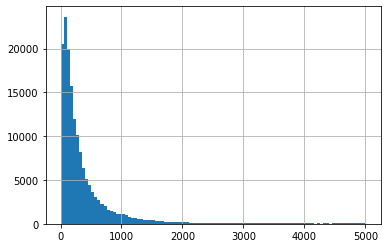

In [18]:
# distribution of text lengths
lens.hist(bins=100)

In [19]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# #create a 'none' label so we can see how many comments have no labels
# df_train['none'] = 1-df_train[label_cols].max(axis=1)

df_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


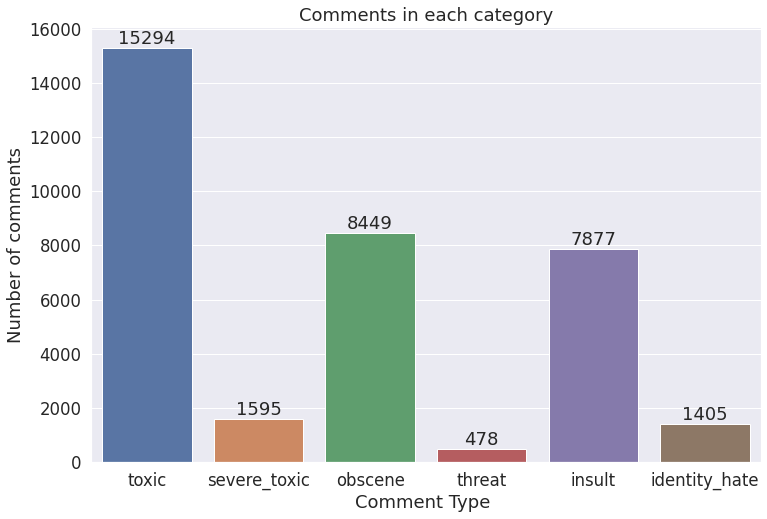

In [20]:
#Counting the number of comments under each label
sns.set(font_scale = 1.5)
categories = list(df_train.columns.values)
plt.figure(figsize=(12,8))
ax = sns.barplot(categories[2:], df_train.iloc[:,2:].sum().values)
plt.title("Comments in each category")
plt.ylabel('Number of comments')
plt.xlabel('Comment Type ')
#adding the text labels
rects = ax.patches
labels = df_train.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

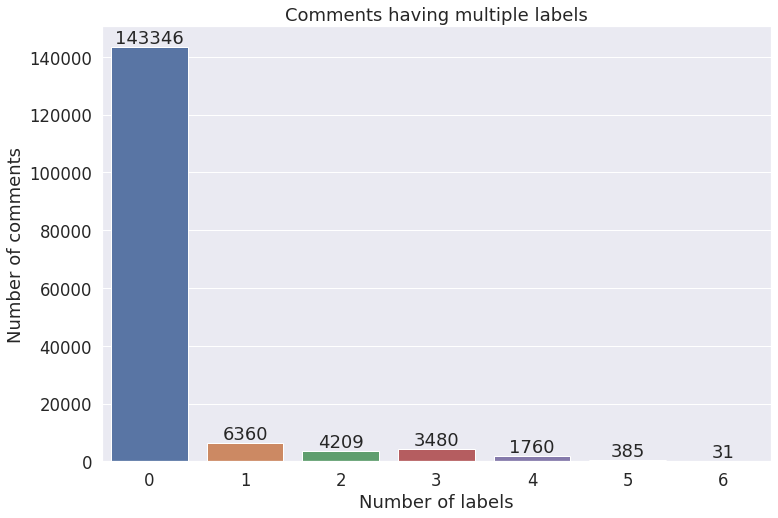

In [21]:
#Counting the number of comments having multiple labels
sns.set(font_scale = 1.5)
rowSums = df_train.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[:]
plt.figure(figsize=(12,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Comments having multiple labels")
plt.ylabel('Number of comments')
plt.xlabel('Number of labels')
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

### Extract Toxic column only

In [22]:
df_toxic = df_train.iloc[:,0:3]
df_toxic.head()

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


In [23]:
df_toxic.groupby([('toxic')]).size()

toxic
0    144277
1     15294
dtype: int64

In [24]:
s = df_toxic.toxic
counts=s.value_counts()
percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str)+'%'
pd.DataFrame({'counts': counts, 'per100':percent100})

,counts,per100
0,144277,90.4%
1,15294,9.6%


### Random sampling (positive:negative = 50:50)

In [25]:
diff_num = df_toxic[df_toxic.toxic==0].shape[0]-df_toxic[df_toxic.toxic==1].shape[0]

np.random.seed(42)
drop_indices = np.random.choice(df_toxic[df_toxic.toxic==0].index, diff_num, replace=False)

df_toxic_balanced = df_toxic.drop(drop_indices)

In [26]:
s = df_toxic_balanced.toxic
counts=s.value_counts()
percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str)+'%'
pd.DataFrame({'counts': counts, 'per100':percent100})

,counts,per100
0,15294,50.0%
1,15294,50.0%


In [27]:
sub_sample_num = 200
df_sampled = df_toxic_balanced.groupby('toxic',as_index = False,group_keys=False).apply(lambda s: s.sample(sub_sample_num, replace=True))

In [28]:
s = df_sampled.toxic
counts=s.value_counts()
percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str)+'%'
pd.DataFrame({'counts': counts, 'per100':percent100})

,counts,per100
0,200,50.0%
1,200,50.0%


In [29]:
from transformers import GPT2Tokenizer
from keras.preprocessing.sequence import pad_sequences

gpt2_model_name = 'gpt2'

tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_name, do_lower_case=True)
MAX_LEN = 128

def tokenize_sentences(sentences, tokenizer, max_seq_len = 128):
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len,  # Truncate all sentences.
                    )
        
        tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences

def create_attention_masks(tokenized_and_padded_sentences):
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

input_ids = tokenize_sentences(df_sampled['comment_text'], tokenizer, MAX_LEN)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
attention_masks = create_attention_masks(input_ids)

  0%|          | 0/400 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [30]:
TEST_SIZE = 0.2
label_cols = ['toxic']
labels =  df_sampled[label_cols].values

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=TEST_SIZE)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=TEST_SIZE)

train_size = len(train_inputs)
validation_size = len(validation_inputs)

In [31]:
BATCH_SIZE = 16
NR_EPOCHS = 1

def create_dataset(data_tuple, epochs=1, batch_size=32, buffer_size=10000, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    if train:
        dataset = dataset.prefetch(1)
    
    return dataset

train_dataset = create_dataset((train_inputs, train_masks, train_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)
validation_dataset = create_dataset((validation_inputs, validation_masks, validation_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)

## 2. GPT-2 Model
- Load the pretrained GPT-2 base-model from Transformers library
- Take the first hidden-state from GPT-2 output (corresponding to CLS token) and feed it into a Dense layer with 6 neurons and sigmoid activation (Classifier). The outputs of this layer can be interpreted as probabilities for each of the 6 classes.

In [68]:
from transformers import TFGPT2Model
from tensorflow.keras.layers import Dense, Flatten

class GPT2Classifier(tf.keras.Model):    
    def __init__(self, gpt2: TFGPT2Model, num_classes: int):
        super().__init__()
        self.gpt2 = gpt2
        self.classifier = Dense(num_classes, activation='sigmoid')
        
    @tf.function
    def call(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
        outputs = self.gpt2(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask)
        cls_output = outputs[1]
        print("blah01: ", cls_output)
        cls_output = self.classifier(cls_output)
                
        return cls_output

model = GPT2Classifier(TFGPT2Model.from_pretrained(gpt2_model_name), len(label_cols))

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


## 3. Training Loop
- Use BinaryCrossentropy as loss function (is calculated for each of the output 6 output neurons ...that's like training 6 binary classification tasks at the same time) 
- Use the AdamW optimizer with 1-cycle-policy from the Transformers library
- AUC evaluation metrics

In [69]:
import time
from transformers import create_optimizer

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = validation_size // BATCH_SIZE

# | Loss Function
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)
train_loss = tf.keras.metrics.Mean(name='train_loss')
validation_loss = tf.keras.metrics.Mean(name='test_loss')

# | Optimizer (with 1-cycle-policy)
warmup_steps = steps_per_epoch // 3
total_steps = steps_per_epoch * NR_EPOCHS - warmup_steps
optimizer = create_optimizer(init_lr=2e-5, num_train_steps=total_steps, num_warmup_steps=warmup_steps)

# | Metrics
train_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]
validation_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]

@tf.function
def train_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(token_ids, attention_mask=masks)
        loss = loss_object(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables), 1.0)

    train_loss(loss)

    for i, auc in enumerate(train_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
        
@tf.function
def validation_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    predictions = model(token_ids, attention_mask=masks, training=False)
    v_loss = loss_object(labels, predictions)

    validation_loss(v_loss)
    for i, auc in enumerate(validation_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
                                              
def train(model, train_dataset, val_dataset, train_steps_per_epoch, val_steps_per_epoch, epochs):
    for epoch in range(epochs):
        print('=' * 50, f"EPOCH {epoch}", '=' * 50)

        start = time.time()

        for i, (token_ids, masks, labels) in enumerate(tqdm(train_dataset, total=train_steps_per_epoch)):
            train_step(model, token_ids, masks, labels)
            if i % 10 == 0: #TODO: 1000
                print(f'\nTrain Step: {i}, Loss: {train_loss.result()}')
                for i, label_name in enumerate(label_cols):
                    print(f"{label_name} roc_auc {train_auc_metrics[i].result()}")
                    train_auc_metrics[i].reset_states()
        
        for i, (token_ids, masks, labels) in enumerate(tqdm(val_dataset, total=val_steps_per_epoch)):
            validation_step(model, token_ids, masks, labels)

        print(f'\nEpoch {epoch+1}, Validation Loss: {validation_loss.result()}, Time: {time.time()-start}\n')

        for i, label_name in enumerate(label_cols):
            print(f"{label_name} roc_auc {validation_auc_metrics[i].result()}")
            validation_auc_metrics[i].reset_states()

        print('\n')

        
train(model, train_dataset, validation_dataset, train_steps_per_epoch=steps_per_epoch, val_steps_per_epoch=validation_steps, epochs=NR_EPOCHS)

================================================== EPOCH 0 ==================================================


  0%|          | 0/20 [00:00<?, ?it/s]

blah01:  (<tf.Tensor 'tfgpt2_model_9/transformer/h_._0/attn/stack:0' shape=(2, 16, 12, 128, 64) dtype=float32>, <tf.Tensor 'tfgpt2_model_9/transformer/h_._1/attn/stack:0' shape=(2, 16, 12, 128, 64) dtype=float32>, <tf.Tensor 'tfgpt2_model_9/transformer/h_._2/attn/stack:0' shape=(2, 16, 12, 128, 64) dtype=float32>, <tf.Tensor 'tfgpt2_model_9/transformer/h_._3/attn/stack:0' shape=(2, 16, 12, 128, 64) dtype=float32>, <tf.Tensor 'tfgpt2_model_9/transformer/h_._4/attn/stack:0' shape=(2, 16, 12, 128, 64) dtype=float32>, <tf.Tensor 'tfgpt2_model_9/transformer/h_._5/attn/stack:0' shape=(2, 16, 12, 128, 64) dtype=float32>, <tf.Tensor 'tfgpt2_model_9/transformer/h_._6/attn/stack:0' shape=(2, 16, 12, 128, 64) dtype=float32>, <tf.Tensor 'tfgpt2_model_9/transformer/h_._7/attn/stack:0' shape=(2, 16, 12, 128, 64) dtype=float32>, <tf.Tensor 'tfgpt2_model_9/transformer/h_._8/attn/stack:0' shape=(2, 16, 12, 128, 64) dtype=float32>, <tf.Tensor 'tfgpt2_model_9/transformer/h_._9/attn/stack:0' shape=(2, 16,

ValueError: ignored

Model: "roberta_classifier_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_roberta_model_7 (TFRober  multiple                 124645632 
 taModel)                                                        
                                                                 
 dense_7 (Dense)             multiple                  769       
                                                                 
Total params: 124,646,401
Trainable params: 124,646,401
Non-trainable params: 0
_________________________________________________________________


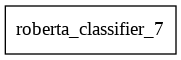

In [ ]:
model.summary()

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

## 4. Run predictions on test-set & save submission

In [ ]:
test_input_ids = tokenize_sentences(df_test['comment_text'], tokenizer, MAX_LEN)
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
test_attention_masks = create_attention_masks(test_input_ids)

In [ ]:
TEST_BATCH_SIZE = 32
test_steps = len(df_test) // TEST_BATCH_SIZE

test_dataset = create_dataset((test_input_ids, test_attention_masks), batch_size=TEST_BATCH_SIZE, train=False, epochs=1)

df_submission = pd.read_csv(subm_path, index_col='id')

for i, (token_ids, masks) in enumerate(tqdm(test_dataset, total=test_steps)):
    sample_ids = df_test.iloc[i*TEST_BATCH_SIZE:(i+1)*TEST_BATCH_SIZE]['id']
    predictions = model(token_ids, attention_mask=masks).numpy()

    df_submission.loc[sample_ids, label_cols] = predictions

In [ ]:
df_submission.to_csv('submission.csv')

In [ ]:
df_submission